In [45]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read in data
df_train_original = pd.read_csv(r"/root/data-science-projects-1/house-price-prediction/train.csv")
df_test_original = pd.read_csv(r"/root/data-science-projects-1/house-price-prediction/test.csv")

# Creating Duplicate Dataframe 
df_train_temp = df_train_original.copy()
df_test = df_test_original.copy()

# Creating a holdout dataset to be used in model blending
df_train = df_train_temp.sample(frac=0.8, random_state=200)
df_holdout = df_train_temp.drop(df_train.index)

The objective of this project is simply to create predictive models using any library available in Python. I opted to use the [Kaggle House Prices Competition Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) since the dataset is readily available, does not require too much cleaning/wrangling, and predictions can be evaluated on the competition leaderboard.

The House Price Competition contains 2 datasets, Train and Test. The training dataset includes 1 dependent variable (SalesPrice), and 79 explanatory variables from which to predict SalesPrice. The Test dataset contains just the 79 explanatory variables. My task was to make the best predictions possible on houses in the Test dataset.

This notebook demonstrates the following approach:

- Data wrangling (Light exploration, followed by removing and transforming some variables)
- Split the training dataset into training and validation datasets
- Fit a model using a Scikit-Learn pipeline (Data Preprocessing + fitting XGBoost/LightGBM estimators with a Randomized Search across their respective hyperparameters)
- Evaluate and visualize model performance
- Implement an automated approach to selecting hyperparameters (HyperOpt)
- Make predictions

## Visualising the Dependent Variable (SalePrice)

The SalePrice variable has quite a strong positive skew, but there are still a lot of houses that sold at least 2x above the mode.

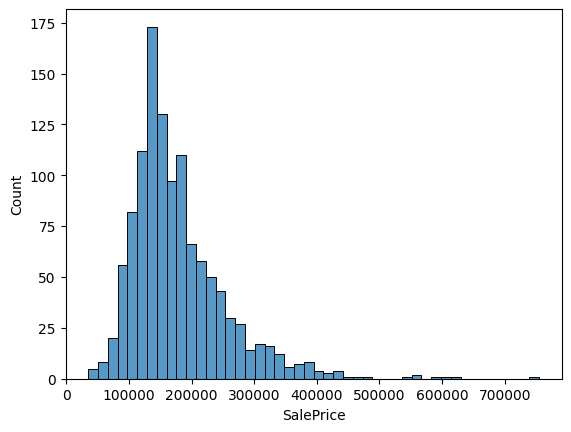

In [46]:
sns.histplot(data=df_train, x="SalePrice")
plt.show()

## Data Wrangling

### Removing Id Column
The Id column simply identifies the row in the dataset and has no predictive power.

In [47]:
# Drop the ID column
df_train = df_train.drop(columns="Id")

### Checking Datatypes

The "MSSubClass" category uses integers to specify types of dwelling, but these integers simply refer to categories.
I will change the datatype of this column from int to str.

Note: I wasn't sure how to deal with the "MoSold" category. The current datatype is int and values are between 1-12 for each month. Changing this to a category may miss some seasonality, since, for example, categories 3 & 4 (March and April) would be treated completely separately in the model.

In [48]:
# Transformation 1: int > str
df_train["MSSubClass"] = df_train["MSSubClass"].astype("str")

# Apply same to df_test
df_test["MSSubClass"] = df_test["MSSubClass"].astype("str")

### Checking missing values

There are a few variables with many missing values. However, I will include these variables since I'll be using decision tree algorithms, which are robust against missing values. 
(Side note: I tried removing all variables with over 30% missing values, but the accuracy of predictions deteriorated)

In [49]:
df_train.isna().sum().sort_values(ascending=False).head(10)

PoolQC          1164
MiscFeature     1124
Alley           1095
Fence            936
FireplaceQu      567
LotFrontage      212
GarageYrBlt       67
GarageCond        67
GarageType        67
GarageFinish      67
dtype: int64

### Checking Variable Skewness

#### Log Transform

In Machine Learning algorithms, the distribution of a variable can have a large effect on its usefulness in making predictions. For heavily skewed variables (as in the image below), potentially important information can be lost in lower value ranges, since higher values stretch the scale and cause lower values to be banded closely together. In this case, a log transform opens up the space between values by readjusting the scale, making it easier for an algorithm to learn how small differences in independent variables affect the dependent variable.

<img src="./log_transform.png" width="400">

Thus, it is common to log transform variables with high skewness to produce more predictive models. The following is the top 10 variables by skewness, according to the skew method in Pandas (which in turn implements [Scipy's skew](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) method with bias set to False)

In [50]:
# List variables with highest "skew"
df_train.select_dtypes(include=["int64","float64"]).skew().sort_values(ascending=False).head(10)

MiscVal          22.425143
PoolArea         17.137136
LotArea          12.920239
3SsnPorch         9.385945
LowQualFinSF      9.038897
KitchenAbvGr      4.462132
BsmtFinSF2        4.359013
BsmtHalfBath      4.264403
ScreenPorch       4.245624
EnclosedPorch     3.098296
dtype: float64

#### Considering the Removal/Transformation of Highly-Skewed Variables

The skewness of the "MiscVal", "LowQualFinSF", "3SsnPorch" and "PoolArea" variables is a result of the vast majority of values being 0, with a few that are not. The existence of  a non-zero value for one of these variables could end up being fairly predictive; for example, the PoolArea variable will only be non-zero for a house with a pool, and a pool is likely to add to the value of a property. Nevertheless, I removed these variables to see if predictions would improve, but they predictably become less accurate.

The distribution of the "LotArea" variable was highly skewed not because most values are zero, but more likely due to the fact that the area of a house lot follows a long-tail distribution - most houses have a small lot, but a larger mansion will have a correspondingly large lot area. This information seems predictive, so I will log transform the variable to help the machine learning algorithm make better predictions even with small differences in LotArea at the lower end of the range of values.

Shown in the first image of this post, the dependent variable "SalePrice" is also highly skewed. I will also log transform this variable.

The visualizations below show the distribution of values for the top 5 variables by skewness. 

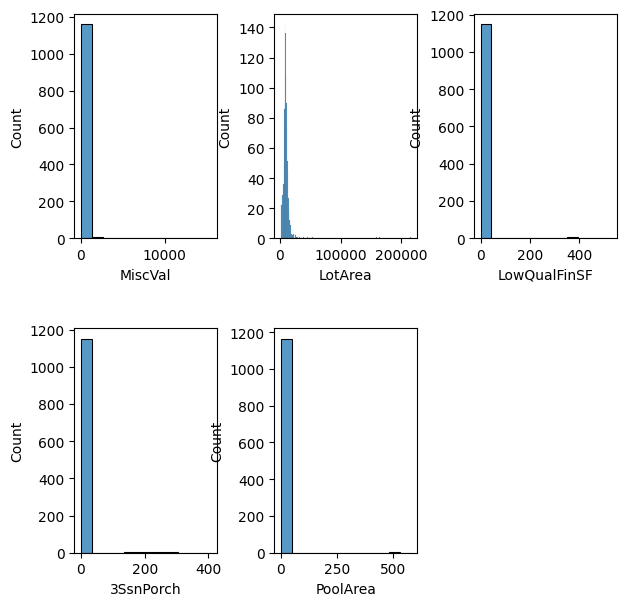

In [51]:
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 3, 1)
sns.histplot(data=df_train, x="MiscVal", ax=ax)
ax = fig.add_subplot(2, 3, 2)
sns.histplot(data=df_train, x="LotArea", ax=ax)
ax = fig.add_subplot(2, 3, 3)
sns.histplot(data=df_train, x="LowQualFinSF", ax=ax)
ax = fig.add_subplot(2, 3, 4)
sns.histplot(data=df_train, x="3SsnPorch", ax=ax)
ax = fig.add_subplot(2, 3, 5)
sns.histplot(data=df_train, x="PoolArea", ax=ax)

plt.show()

**Side note:** Since this is the first time I've log transformed skewed variables during data wrangling, and later in the process I will standardize all numerical variables to have 0 mean and unit variance with StandardScaler(), I gave some thought to ensuring the two processes don't interfere with each other.

Standard scaling is just a linear transform, and the shape of the distribution won't change as a result. A log transform changes the shape of the distribution, in this case reducing skew, and also changes the mean and variance. The resulting distributions are shown below.

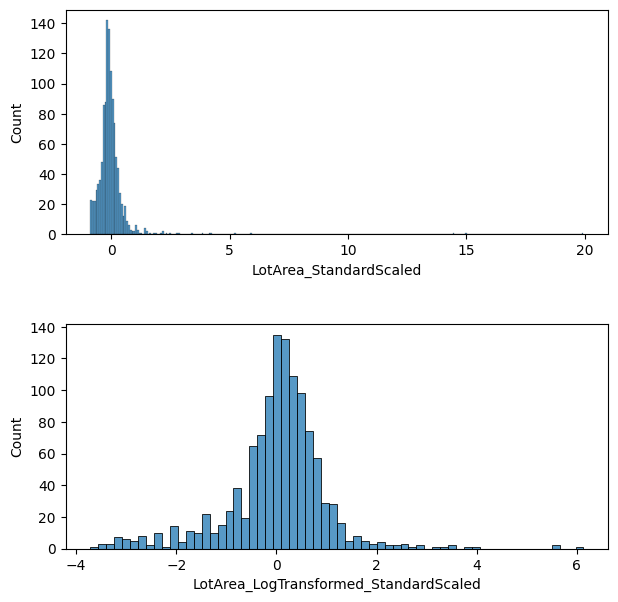

In [52]:
# Setup StandardScaler and LotArea variable
scaler = StandardScaler()
t = np.asarray(df_train['LotArea'])
t = t.reshape(-1,1)
d = {"LotArea_StandardScaled": scaler.fit_transform(t).flatten(), "LotArea_LogTransformed_StandardScaled": scaler.fit_transform(np.log(t)).flatten()}

# Create a temporary dataframe to compare distributions
df_scaling = pd.DataFrame(data=d)

# Visualize
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 1, 1)
sns.histplot(data=df_scaling, x="LotArea_StandardScaled", ax=ax)
ax = fig.add_subplot(2, 1, 2)
sns.histplot(data=df_scaling, x="LotArea_LogTransformed_StandardScaled", ax=ax)

plt.show()

Applying a log transform followed by standardization appears to be a common technique in machine learning to create more predictive models, and the visualizations above show that I am not transforming the variable in weird and unexpected ways.

In [53]:
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
863,20,RL,70.0,7931,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,7,2009,WD,Normal,132500
874,50,RM,52.0,5720,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2009,WD,Abnorml,66500
1448,50,RL,70.0,11767,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,5,2007,WD,Normal,112000
1425,20,RL,80.0,10721,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2008,WD,Normal,142000
991,70,RM,121.0,17671,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,11,2009,WD,Normal,168000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,50,RL,51.0,4712,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,8,2006,WD,Abnorml,121600
574,80,RL,70.0,10500,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,GdWo,NaN,0,12,2007,WD,Normal,139000
1286,20,RL,NaN,9790,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,143000
948,60,RL,65.0,14006,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2006,WD,Normal,192500


In [54]:
# Log transform the LotArea variable
df_train['LotArea'] = np.log(df_train['LotArea'])
df_holdout['LotArea'] = np.log(df_holdout['LotArea'])
df_test['LotArea'] = np.log(df_test['LotArea'])

# Log transform the SalePrice variable
df_train['SalePrice'] = np.log(df_train['SalePrice'])
df_holdout['SalePrice'] = np.log(df_holdout['SalePrice'])

### Removing Variables with High Multicollinearity
Keeping sets of variables that correlate strongly with each other can contribute to overfitting, so I will discover and remove these.
Below is a correlation matrix of all numerical variables.

In [55]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

The list below is a summary of all variable pairs with a correlation coefficient above 0.7 or below -0.7. I will keep variables that are highly correlated with SalePrice since they will be useful in prediction. The following variables are highly correlated only with each other, so they can be removed: GarageYrBlt, TotalBsmtSF, TotRmsAbvGrd, GarageCars.

In [56]:
# Remove one variable in variable pairs where the correlation coefficient is above 0.7
threshold = 0.7
mask = corrmat.abs() > threshold
mask_2 = corrmat.abs() < 1
corrmat.where(mask & mask_2).stack()

OverallQual   SalePrice       0.816949
YearBuilt     GarageYrBlt     0.824625
TotalBsmtSF   1stFlrSF        0.841139
1stFlrSF      TotalBsmtSF     0.841139
GrLivArea     TotRmsAbvGrd    0.826153
TotRmsAbvGrd  GrLivArea       0.826153
GarageYrBlt   YearBuilt       0.824625
GarageCars    GarageArea      0.878865
GarageArea    GarageCars      0.878865
SalePrice     OverallQual     0.816949
dtype: float64

In [57]:
# Remove variables with high collinearity
df_train = df_train.drop(columns=['GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageCars'])

## Data Preprocessing
After going through a more manual process of preparing data, there are still a few steps to take across all numerical and categorical variables.

### Numerical values
- Impute missing values using the median value of the column.
- Standardize the scale of each variable by removing the mean and scaling to unit variance (variance = 1).

In [58]:
# preprocessing for numeric columns
imp_median = SimpleImputer(strategy="median", add_indicator=True)
scaler = StandardScaler()

### Categorical variables
- Impute a "missing_value" string where values are missing.
- One hot encode all categorical variables.

In [59]:
# preprocessing for categorical columns
imp_constant = SimpleImputer(strategy="constant")
ohe = OneHotEncoder(handle_unknown="ignore")

### Create pipeline and split data
Applying data transforms and then fitting a model is commonly acheived using a scikit-learn pipeline. In this case, I'll use it to separate numerical and categorical variables, apply the relevant transformations to each, then fit a Random Forest Regression estimator using default values for hyperparameters.

Scikit-learn also offers a method to split the training dataset into training and validation datasets, which I will implement at a ratio of 8:2.

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# select columns by data type
num_cols = make_column_selector(dtype_include="number")
cat_cols = make_column_selector(dtype_exclude="number")

# all preprocessing
preprocessor = make_column_transformer(
    (make_pipeline(imp_median, scaler), num_cols),
    (make_pipeline(imp_constant, ohe), cat_cols))

pipe = Pipeline([('preprocessing', preprocessor), ('clf', RandomForestRegressor())])

# Define X (independent variables) and y (dependent variable)
X = df_train.drop(columns="SalePrice")
y = df_train["SalePrice"]

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2)

## Setting a baseline before optimization

Before going ahead with any feature engineering or hyperparameter optimization, I'll first establish a baseline that I expect to beat.

In [61]:
pipe.fit(X_train, y_train)
print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Validation set score: ' + str(pipe.score(X_valid,y_valid)))

Training set score: 0.9795797215933942
Validation set score: 0.8735881766608095


## Search Hyperparameters using RandomizedSearchCV

Next, I will create two models using XGBoost, and LightGBM.

Both of these algorithms make use of decision trees. Decision Trees split data by asking questions about each column of independent variables, then judging how predictive each split of values in each column ends up being on the column being predicted. The [StatQuest video on Decision Trees](https://www.youtube.com/watch?v=_L39rN6gz7Y) is a great introduction.

**Random Forest** - Theoretically, a single decision tree could be created that makes exact predictions on the training set by finely splitting each independent variable until it perfectly predicts the dependent variable. Since small changes to the indepedent variables would result in completely different decision trees, a single decision tree would be unlikely to generalize well to new data. This is known as overfitting, and the model itself it said to have high variance. The Random Forest algorithm builds multiple decision trees, and merges them together to get a more accurate and stable prediction. Merging the predictions of many trees lowers the variance of the model and makes the resulting ensemble model more generalizable, a process known as "Bagging".

A line of best fit with high variance, clearly overfit to the training data, is shown below.

<img src="./random_forest_high_variance.png" width="400">

Source: Wade, Corey. Hands-On Gradient Boosting with XGBoost and scikit-learn: Perform accessible machine learning and extreme gradient boosting with Python (p.84).

**XGBoost** - While a model with high variance will not generalize well, a model that just cuts a straight line will simply not make good predictions. Such a model is said to have high bias, as shown below.

<img src="./high_bias.png" width="400">

Source: Wade, Corey. Hands-On Gradient Boosting with XGBoost and scikit-learn: Perform accessible machine learning and extreme gradient boosting with Python (p.83).

While bagging reduces variance by combining the predictions of multiple decision trees, boosting uses the error from these trees to inform models with new trees. XGBoost specifically uses gradient boosting, in which the residuals of the predictions of each tree are summed, and this sum is used to score the model. Iterating through this process converges on a model with lower loss, to the extent that these models are more predictive and have lower bias.

Since the resulting predictions will be greatly influenced by the number of trees (estimators) created and how much each new tree learns from previously constructed trees, the n_estimators and learning rate hyperparameters are perhaps the two most important hyperparameters to tune when using XGBoost.

**LightGBM** - Similiar to XGBoost, LightGBM also uses a combination of bagging and boosting to combine multiple tree estimators. The fundamental difference between the two is that XGBoost expands trees *level-wise*, while LightGBM expands trees *leaf-wise*. In the following images, black nodes represent inexpandable leaves, while green nodes represent leaves that can be be further split to grow the tree.

<img src="./level-wise.png" width="400">

<img src="./leaf-wise.png" width="400">

Source: [XGBoost vs LightGBM: How Are They Different](https://neptune.ai/blog/xgboost-vs-lightgbm)

Since XGBoost builds decision trees level-by-level, and each level includes more than one column, there is less chance of overfitting by splitting the training data down to specific values in specific columns relative to LightGBM. However, by growing *leaf-wise*, LightGBM can very quickly generate highly accurate models. To control for overfitting, both the XGBoost and LightGBM algorithms have a "max_depth" hyperparameter, which refers to the upper bound of layers in a single decision tree estimator. The LightGBM algorithm typically requires a lower max_depth than XGBoost.

In [62]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

search_space_random = [
    {
        'clf': (xgb.XGBRegressor(), ),
        'clf__n_estimators': np.arange(100,1001,100),
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__max_depth': np.arange(1,151,10)
    },
    {
        'clf': (lgb.LGBMRegressor(), ),
        'clf__n_estimators': np.arange(100,1001,100),
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__max_depth': np.arange(1,50,5)
    }
]

random_search = RandomizedSearchCV(pipe, search_space_random, cv=5, error_score="raise")

random_search.fit(X_train,y_train)
print('Training set score: ' + str(random_search.score(X_train,y_train)))
print('Validation set score: ' + str(random_search.score(X_valid,y_valid)))

best_params = random_search.best_params_
print("From random search, the estimator and hyperparameters resulting in the best predictions on the validation set were:")
print(best_params)

Training set score: 0.9999655162276678
Validation set score: 0.8835147851340168
From random search, the estimator and hyperparameters resulting in the best predictions on the validation set were:
{'clf__n_estimators': 800, 'clf__max_depth': 41, 'clf__learning_rate': 0.1, 'clf': LGBMRegressor(max_depth=41, n_estimators=800)}


## Analyze the results
The following plots show the mean test scores for different hyperparameter values used with the XGBoost and LightGBM estimators. In a typical flow for this kind of project, I would use this to determine the next values to use in the hyperparameter search space. This time however, I decided to automate the hyperparameter tuning process.

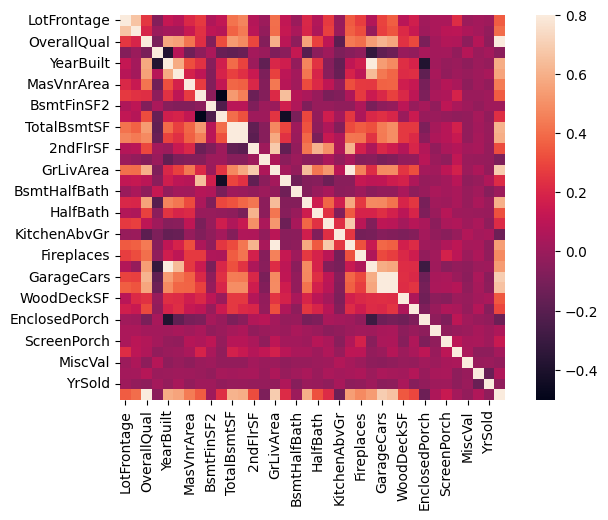

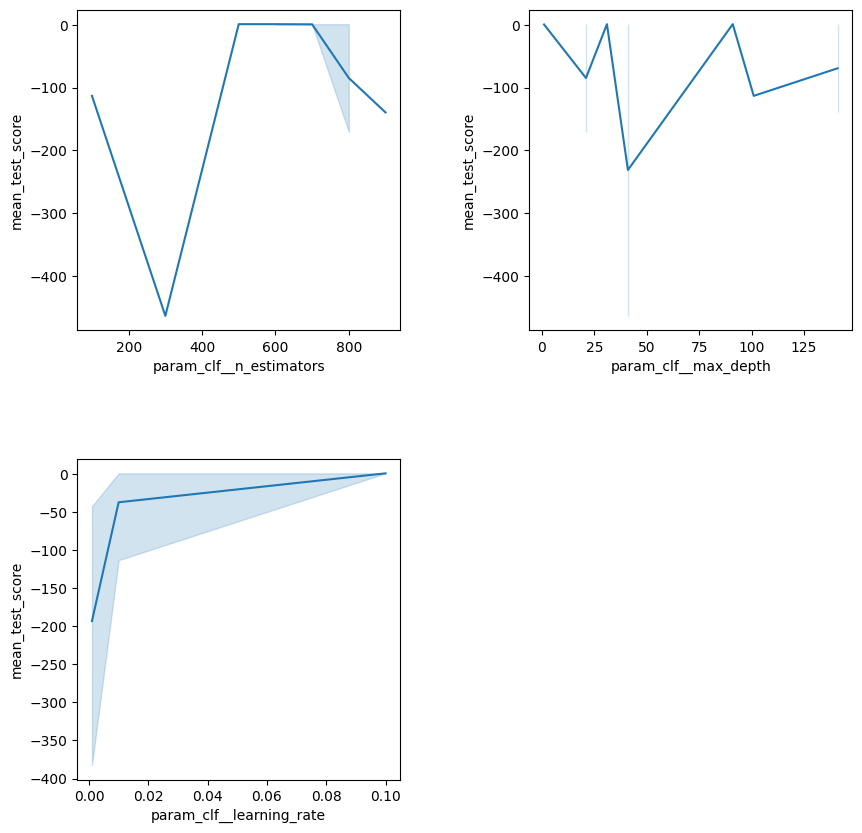

In [63]:
result_df = pd.DataFrame.from_dict(random_search.cv_results_, orient='columns')

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.lineplot(data=result_df, x='param_clf__n_estimators', y='mean_test_score', ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.lineplot(data=result_df, x='param_clf__max_depth', y='mean_test_score', ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.lineplot(data=result_df, x='param_clf__learning_rate', y='mean_test_score', ax=ax)

plt.show()

## Automated Hyperparameter Tuning with HyperOpt

While my initial approach to tuning model hyperparameters was to visualize accuracy differences for different hyperparameter values and conduct another grid/random search on that basis, another method is to automate the process entirely using HyperOpt, which applies Bayesian optimization to the hyperparameter selection process.

To understand this process, I used [these lecture notes](https://www.cs.cornell.edu/courses/cs4787/2019sp/notes/lecture16.pdf) from a CS course at Cornell.

Bayes Theorem can be used to work out the conditional probability of an outcome based on previous outcomes. If we want to optimize a function f(x) where x is any real number, we can model f as a probability distribution. We can then compute f at various values of x to get observed instances of x and, since f is defined as a probability distribution, we can infer f at unobserved instances of x. In the case of hyperparameter optimization, we follow the above process by modelling the hyperparameter as function f(x).

Encoding the probability distribution of f based on observed instances is typically done using a Gaussian Process prior. In essence, the probability distribution is modelled as a multivariate Gaussian distribution, and taking calculating more and more values for x will converge to the true mean and variance of x due to Central Limit Theorem (an extension of which shows that it can also apply to multidimensional Gaussian distributions).

Choosing the value of x to evaluate next requires a separate "acquisition function". There are a few ways to do this, but some popular approaches include:
- Probability of Improvement Function
    - Maximize the probability that the next value of x will be the best found so far.
- Expected Improvement
    - Minimize the expected improvement in f(x) AFTER the next x is observed.
- Lower Confidence Bound
    - Minimize Regret over optimization sequence.

### K-Fold Cross-Validation in Hyperparameter Optimization

While cross-validation gives a better picture of the accuracy/loss of a model by averaging model performance on different splits, the downside is that the same model must be fit and make predictions k times. This is time that could have been used refining hyperparameter combinations and, all else equal, it is likely this is a better use of time. For this implementation, I have not used K-fold cross validation.

In [102]:
from hyperopt import hp
from sklearn.metrics import mean_squared_error

# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth':        hp.choice('max_depth', np.arange(1, 300, dtype=int)),
    # "Stop trying to split once your sample size in a node goes below a given threshold"
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 40, dtype=int)),
    # The fraction of features (randomly selected) that will be used to train each tree
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    # The fraction of the training samples (randomly selected) that will be used to train each tree
    'subsample':        hp.uniform('subsample', 0, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(1, 1000, dtype=int))
}

xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth':        hp.choice('max_depth', np.arange(1, 151, dtype=int)),
    # "Stop trying to split once your sample size in a node goes below a given threshold"
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 40, dtype=int)),
    # The fraction of features (randomly selected) that will be used to train each tree
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    # The fraction of the training samples (randomly selected) that will be used to train each tree
    'subsample':        hp.uniform('subsample', 0, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(1, 1000, dtype=int))
}

lgb_fit_params = {
    'eval_metric': 'rmse',
    'verbose' : False,
    'early_stopping_rounds': 10
}

lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [103]:
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval

class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        hyperparams = space_eval(space, result)
        # Not currently returning trials
        return hyperparams

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [104]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Preprocess data using the first step of the pipeline defined earlier
X_train_processed = pipe[0].fit_transform(X_train)
X_valid_processed = pipe[0].transform(X_valid)

obj = HPOpt(X_train_processed, X_valid_processed, y_train, y_valid)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=300)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=300)

100%|██████████| 300/300 [09:55<00:00,  1.98s/trial, best loss: 0.11961432461325223]


## Fitting the best model

Let's see how the two models perform on the validation dataset.

In [112]:
# Create pipeline with optimal hyperparameter values (XGBoost)
pipe_hyperopt_xgb = Pipeline([('preprocessing', preprocessor), ('clf', xgb.XGBRegressor(**xgb_opt['reg_params']))])
pipe_hyperopt_xgb.fit(X_train, y_train, clf__eval_metric="rmse")

print('XGBoost Training set score: ' + str(pipe_hyperopt_xgb.score(X_train,y_train)))
print('XGBoost Validation set score: ' + str(pipe_hyperopt_xgb.score(X_valid,y_valid)))

# Create pipeline with optimal hyperparameter values (LightGBM)
pipe_hyperopt_lgb = Pipeline([('preprocessing', preprocessor), ('clf', lgb.LGBMRegressor(**lgb_opt['reg_params']))])
pipe_hyperopt_lgb.fit(X_train, y_train, clf__eval_metric="rmse")

print('LightGBM Training set score: ' + str(pipe_hyperopt_lgb.score(X_train,y_train)))
print('LightGBM Validation set score: ' + str(pipe_hyperopt_lgb.score(X_valid,y_valid)))


XGBoost Training set score: 0.9867193012277842
XGBoost Validation set score: 0.9091849468852858
LightGBM Training set score: 0.9987120426347157
LightGBM Validation set score: 0.9016132432937388


Both of these models perform better on the validation set than the baseline, and XGBoost takes the edge.

## Make Predictions

After a long process of data wrangling and model selection, I can finally make some predictions. First of all, some columns were deleted in the training set that still exist in the test set, so these need to be removed.

In [109]:
# Find different columns between dataframes
list(set(df_train_original.columns) - set(df_train.columns))

# Define X_test
X_test = df_test.drop(columns=list(set(df_train_original.columns) - set(df_train.columns)))

Next, I will use the XGBoost pipeline to make predictions.

In [110]:
predictions = pipe_hyperopt_xgb.predict(X_test)

# Reverse the log transform
predictions = np.exp(predictions)

d = {"Id":df_test["Id"],"SalePrice":predictions}
submission = pd.DataFrame(data=d)

# Save CSV of predictions to submit to Kaggle
submission.to_csv("submission_dt.csv",index=False)

That's it! At the time of posting, this submission placed 883rd of 5,053 teams on the Kaggle House Prices Leaderboard.

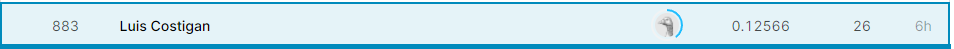

## Finally, saving the preprocessed data for use with other models

### Making predictions on the holdout dataset

In [116]:
# Remove unnecessary columns from data cleansing process
df_holdout_drop_cols = df_holdout.drop(columns=list(set(df_train_original.columns) - set(df_train.columns)))

# Split X,y
X_holdout = df_holdout_drop_cols.drop(columns=["SalePrice"])
X_holdout = X_holdout.reset_index().drop(columns="index")

# Make predictions
holdout_predictions = pipe_hyperopt_xgb.predict(X_holdout)

# Reverse the log transform
holdout_predictions = np.exp(holdout_predictions)

# Put together holdout predictions and actual values
holdout_DT_predictions = pd.DataFrame()
holdout_DT_predictions["DT_predictions"] = holdout_predictions

# Align indices
temp_holdout = pd.DataFrame(df_holdout[df_holdout.columns[-1]])
temp_holdout = temp_holdout.reset_index().drop(columns="index")
holdout_DT_predictions["Actual_SalePrice"] = temp_holdout["SalePrice"]

The below is additional code to save processed data and predictions to a CSV for use in the next blog post.

In [117]:
# Define CreateCSV class that can join X,y for each dataset (having been wrangled/preprocessed)
class CreateCSV:

    def __init__(self, x, y=None):
        self.x = x
        self.y = y

    def convert_to_csv(self, dataset_name):
        df = pd.DataFrame(self.x)
        if isinstance(self.y, pd.Series):
            # Align indices
            y = pd.DataFrame(self.y)
            y = y.set_index(df.index)
            # Append column to end of dataframe
            df = df.join(y)
        else:
            pass

        return df.to_csv("%s_preprocessed" % dataset_name, index=False)

In [118]:
# Apply preprocessing to holdout and test datasets
X_holdout_processed = pipe[0].transform(X_holdout)
X_test_processed = pipe[0].transform(X_test)

# Densify the arrays
X_train_processed_densified =  X_train_processed.todense()
X_valid_processed_densified =  X_valid_processed.todense()
X_holdout_processed_densified = X_holdout_processed.todense()
X_test_processed_densified =  X_test_processed.todense()

# Create data objects to be coverted to CSVs
training = CreateCSV(X_train_processed_densified, y_train)
validation = CreateCSV(X_valid_processed_densified, y_valid)
holdout = CreateCSV(X_holdout_processed_densified, holdout_DT_predictions["Actual_SalePrice"])
holdout_preds = CreateCSV(holdout_DT_predictions["DT_predictions"], holdout_DT_predictions["Actual_SalePrice"])
test = CreateCSV(X_test_processed_densified)

# Convert to CSV
training.convert_to_csv("training")
validation.convert_to_csv("validation")
holdout.convert_to_csv("holdout")
holdout_preds.convert_to_csv("holdout_preds")
test.convert_to_csv("test")